<h3>Preparing baseline model to classify images from Food101 dataset.<h3>

In [ ]:
import torchvision
import torch
from func.get_data import get_food101
import os
from pathlib import Path

DATA_DIR = Path(os.getenv("DATA_DIR"))
TRANSFORMS = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

device = "cuda" if torch.cuda.is_available() else "cpu"

train_data, test_data, class_names = get_food101(transform=TRANSFORMS, data_path=DATA_DIR/"data_food")
class_names[:10]

Preparing food101 dataset in data/data_food...


100%|██████████| 5.00G/5.00G [03:48<00:00, 21.9MB/s]


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#Create file with food classes names

classes_file= Path(os.getenv("CLASSES_DIR")) / "food_classes.txt"

with open(classes_file, "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

In [ ]:
from func.data_setup import create_dataloaders, split_dataset

# Create training 20% split of Food101
train_data_20, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_20, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_20), len(test_data_20)

Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [6]:
# Prepare dataloaders for 20% splits of Food101
train_dataloader_20, test_dataloader_20= create_dataloaders(train_data=train_data_20, test_data=test_data_20, batch_size=32)

In [ ]:
from func.model_setup import create_effnetb2_model
effnetb2_food101, _= create_effnetb2_model(num_classes=len(class_names))

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 126MB/s]


In [ ]:
from torchinfo import summary

summary(effnetb2_food101,
         input_size=(1, 3, 224, 224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
from func.engine import train
from func.utils import set_seeds

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = train(model=effnetb2_food101,
                                 train_dataloader=train_dataloader_20,
                                 test_dataloader=test_dataloader_20,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 epochs=10,
                                 device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810
Epoch: 6 | train_loss: 2.4332 | train_acc: 0.5408 | test_loss: 2.2663 | test_acc: 0.5830
Epoch: 7 | train_loss: 2.4105 | train_acc: 0.5461 | test_loss: 2.2359 | test_acc: 0.5925
Epoch: 8 | train_loss: 2.3877 | train_acc: 0.5479 | test_loss: 2.2388 | test_acc: 0.5922
Epoch: 9 | train_loss: 2.3673 | train_acc: 0.5590 | test_loss: 2.2200 | test_acc: 0.5985
Epoch: 10 | train_loss: 2.3453 | train_acc: 0.5610 | test_loss: 2.2250 | test_acc: 0.5991


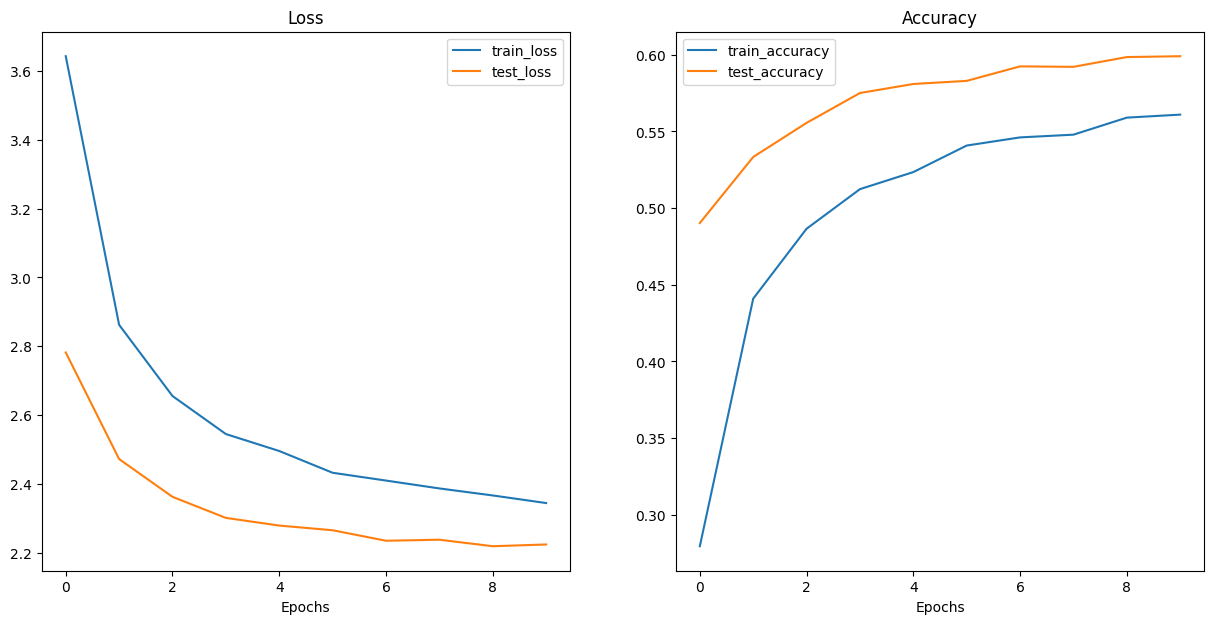

In [ ]:
from func.utils import  save_model
from func.visuals import plot_loss_curves
# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

In [ ]:
# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"
model_dir = Path(os.getenv("MODEL_DIR"))
# Save FoodVision Big model
save_model(model=effnetb2_food101,
                 target_dir=model_dir,
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path(model_dir, effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB
